In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df=pd.read_excel('6sig-Q3.xlsx',sheet_name='Data')
df['Dates']=pd.to_datetime(df['Dates'])
df.head()

,Dates,A_P,AAPL_P,ABBV_P,ABNB_P,ABT_P,ACGL_P,ACN_P,ADBE_P,ADI_P,...,WTW_CAP,WY_CAP,WYNN_CAP,XEL_CAP,XOM_CAP,XYL_CAP,YUM_CAP,ZBH_CAP,ZBRA_CAP,ZTS_CAP
0,2020-01-03,84.57,74.358,88.70,144.71,85.89,43.35,209.80,331.81,118.31,...,26271.2610,21936.9923,15187.4561,32868.6459,297573.6896,14463.9349,30805.7722,30607.8899,13806.5944,63900.3074
1,2020-01-06,84.82,74.950,89.40,139.25,86.34,43.52,208.43,333.71,116.92,...,26303.4042,21892.2838,15157.3968,32821.4509,299858.4869,14370.2939,30787.6245,30431.0014,13912.2805,63409.7192
2,2020-01-07,85.08,74.598,88.89,130.00,85.86,43.16,203.93,333.39,119.58,...,26249.4037,21750.7067,15229.3244,32753.2805,297404.4454,14316.2702,30842.0677,30404.2624,13829.2415,63624.0538
3,2020-01-08,85.92,75.798,89.52,124.80,86.21,42.73,204.33,337.87,120.66,...,26278.9754,21832.6724,15324.8700,32721.8172,292919.4729,14364.8915,30896.5109,30768.3237,13353.1148,63485.9270
4,2020-01-09,87.27,77.408,90.21,137.99,86.44,43.60,206.15,340.45,120.66,...,26357.4047,22011.5066,15260.4572,32795.2315,295161.9592,14429.7199,31141.5052,30564.6962,13291.6443,64328.9767


In [ ]:
# extract ticker
df.set_index('Dates',inplace=True)
df=df.fillna(method='ffill')
price_cols = [col for col in df.columns if col.endswith('_P')]
tickers = [col.replace('_P', '') for col in price_cols]
print("number of stocks:", len(tickers))

number of stocks: 503


In [ ]:
# build price and market cap
prices = df[[ticker + '_P' for ticker in tickers]].copy()
prices.columns = tickers
market_caps = df[[ticker + '_CAP' for ticker in tickers]].copy()
market_caps.columns = tickers
returns = prices.pct_change().fillna(0)
avg_market_cap = market_caps.mean()
mag7 = avg_market_cap.sort_values(ascending=False).head(7).index.tolist()
# print("Mag7 list:", mag7)

#rebalanced every half year
rebal_dates = pd.date_range(start=returns.index[0], end=returns.index[-1], freq='6MS')
# assume returns.index is DatetimeIndex of all trading dates
trading_dates = returns.index.sort_values()

# adjust rebal_dates：if a rebalance day doesn't conclude in trading calendar, choose a day later
adjusted_rebal_dates = []
for d in rebal_dates:
    if d in trading_dates:
        adjusted_rebal_dates.append(d)
    else:
        # find the first \leq than d
        next_trading_day = trading_dates[trading_dates >= d][0]
        adjusted_rebal_dates.append(next_trading_day)

# use rebel dates do backtesting
rebal_dates = pd.to_datetime(adjusted_rebal_dates)
print("rebalance date：", rebal_dates)

rebalance date： DatetimeIndex(['2020-02-03', '2020-08-03', '2021-02-01', '2021-08-02',
               '2022-02-01', '2022-08-01', '2023-02-01', '2023-08-01',
               '2024-02-01', '2024-08-01', '2025-02-03'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
# ---------------------------
# 4.Original Startegy(Short position equally)
# ---------------------------
original_strat_returns = pd.Series(dtype=float)

for i, r_date in enumerate(rebal_dates):
    # define rebalance period: current balance day to next rebalance day
    if i < len(rebal_dates) - 1:
        next_r_date = rebal_dates[i+1]
        period = returns.loc[r_date: next_r_date - pd.Timedelta(days=1)]
    else:
        period = returns.loc[r_date:]

    available_tickers = returns.columns[returns.loc[r_date].notna()]
    mcap_today = market_caps.loc[r_date, available_tickers]

    long_threshold = mcap_today.quantile(0.10)
    short_threshold = mcap_today.quantile(0.90)
    long_stocks = mcap_today[mcap_today <= long_threshold].index.tolist()
    short_stocks = mcap_today[mcap_today >= short_threshold].index.tolist()

    long_weight = 1.0 / len(long_stocks) if long_stocks else 0
    short_weight = 1.0 / len(short_stocks) if short_stocks else 0

    period_returns = []
    for date, row in period.iterrows():
        long_ret = sum(long_weight * row[stock] for stock in long_stocks) if long_stocks else 0
        short_ret = sum(short_weight * row[stock] for stock in short_stocks) if short_stocks else 0
        period_returns.append(long_ret - short_ret)

    # print(long_stocks)
    period_returns_series = pd.Series(period_returns, index=period.index)
    original_strat_returns = pd.concat([original_strat_returns, period_returns_series])

original_strat_returns.sort_index(inplace=True)

In [ ]:
# ---------------------------
# 5. Modigy backtesting strategy: Long market cap lowest 10%, short top 10%, set a limit for short position
# ---------------------------
modified_strat_returns = pd.Series(dtype=float)

c_max=[0.001,0.005,0.01,0.02,0.05]
output_dict={}
for c in c_max:
  modified_strat_returns=None
  for i, r_date in enumerate(rebal_dates):
      if i < len(rebal_dates) - 1:
          next_r_date = rebal_dates[i+1]
          period = returns.loc[r_date: next_r_date - pd.Timedelta(days=1)]
      else:
          period = returns.loc[r_date:]

      available_tickers = returns.columns[returns.loc[r_date].notna()]
      mcap_today = market_caps.loc[r_date, available_tickers]

      long_threshold = mcap_today.quantile(0.10)
      short_threshold = mcap_today.quantile(0.90)
      long_stocks = mcap_today[mcap_today <= long_threshold].index.tolist()
      short_stocks = mcap_today[mcap_today >= short_threshold].index.tolist()

      long_weight = 1.0 / len(long_stocks) if long_stocks else 0
      n_short = len(short_stocks)
      base_weight = 1.0 / n_short if n_short > 0 else 0

      # set upper limit in short position
      weights = {}
      upper_limit = c
      total_reduction = 0.0
      mag7_in_short = [stock for stock in short_stocks if stock in mag7]
      non_mag7_in_short = [stock for stock in short_stocks if stock not in mag7_in_short]

      for stock in short_stocks:
          if stock in mag7_in_short and base_weight > upper_limit:
              weights[stock] = upper_limit
              total_reduction += (base_weight - upper_limit)
          else:
              weights[stock] = base_weight

      if non_mag7_in_short and total_reduction > 0:
          extra_weight = total_reduction / len(non_mag7_in_short)
          for stock in non_mag7_in_short:
              weights[stock] += extra_weight

      period_returns = []
      for date, row in period.iterrows():
          long_ret = sum(long_weight * row[stock] for stock in long_stocks) if long_stocks else 0
          short_ret = sum(weights[stock] * row[stock] for stock in short_stocks) if short_stocks else 0
          period_returns.append(long_ret - short_ret)

      period_returns_series = pd.Series(period_returns, index=period.index)
      modified_strat_returns = pd.concat([modified_strat_returns, period_returns_series])

  modified_strat_returns.sort_index(inplace=True)
  output_dict[c]=modified_strat_returns

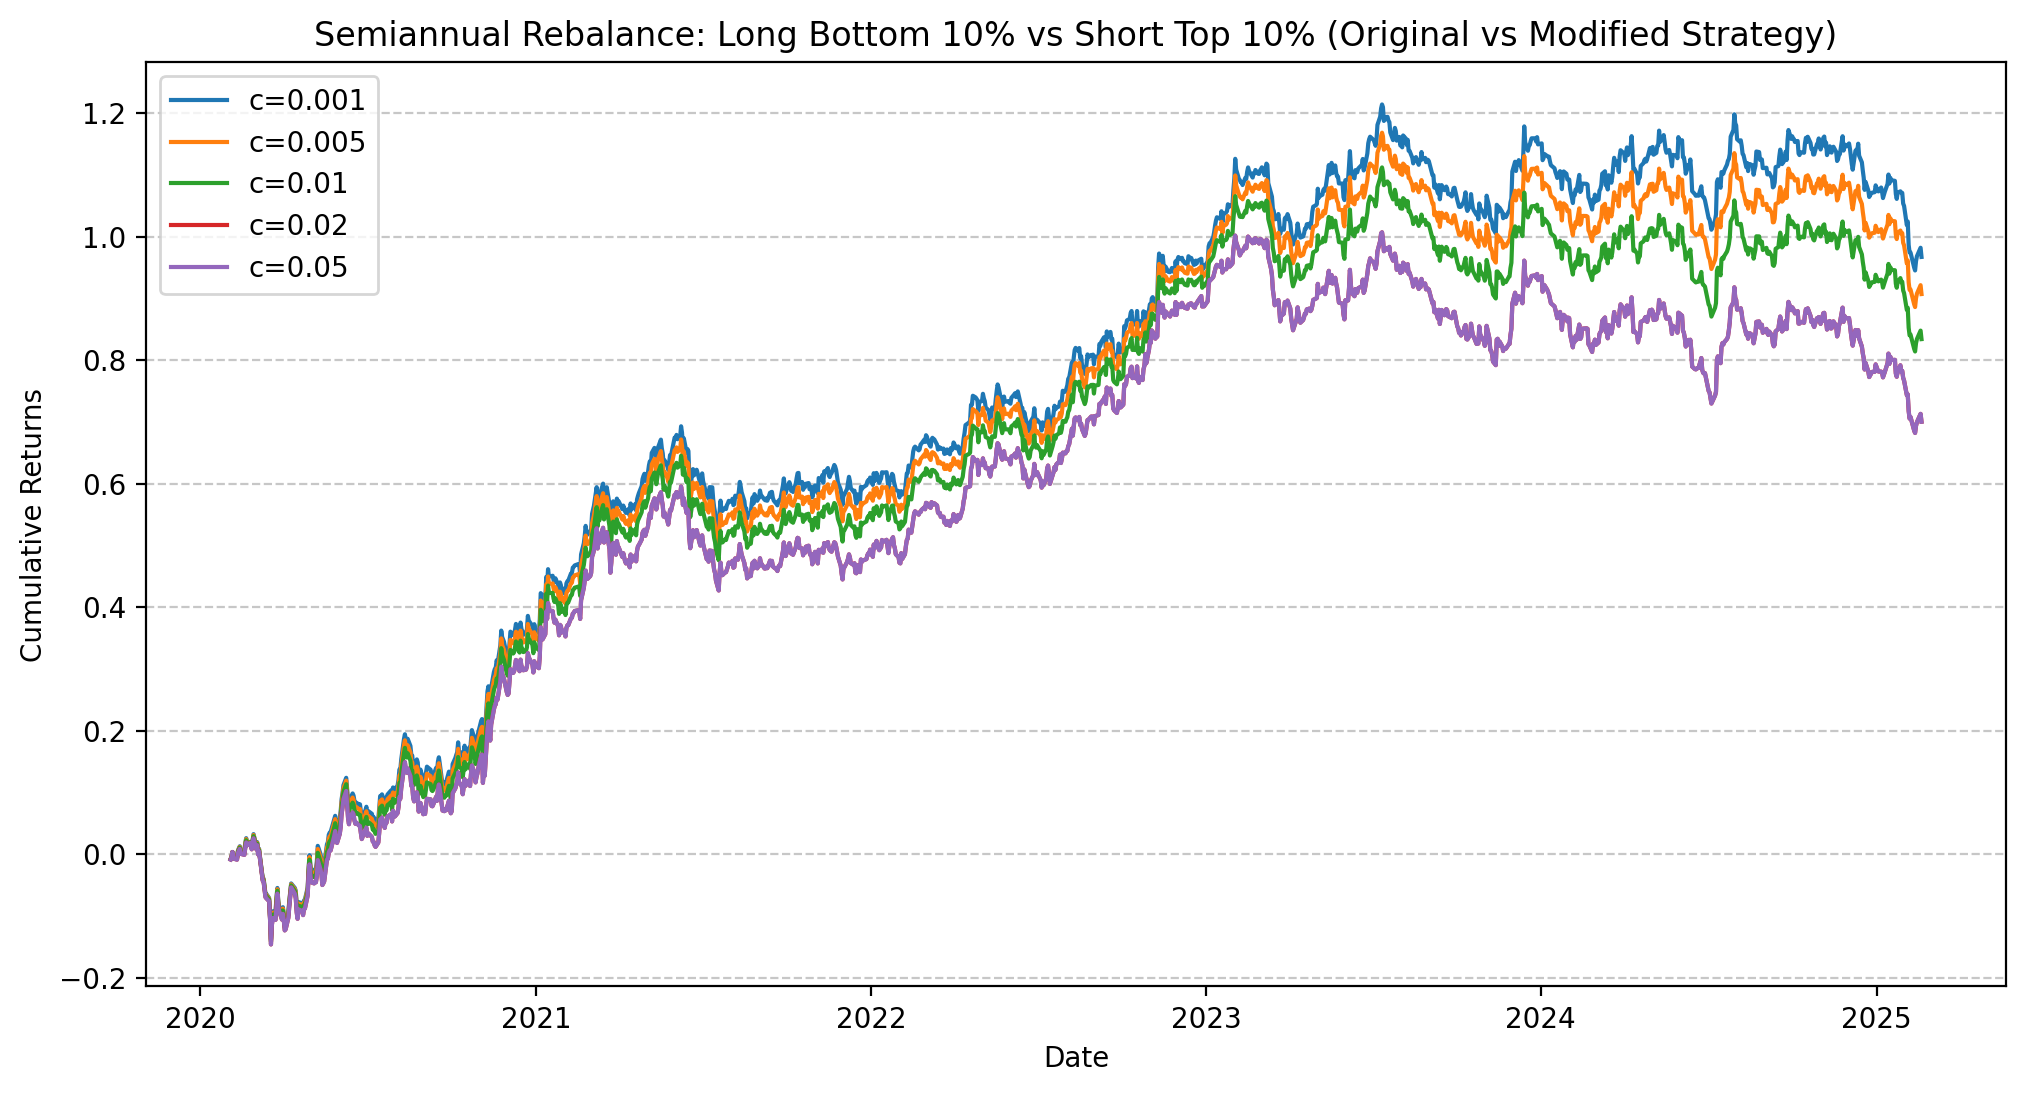

In [ ]:
plt.figure(figsize=(12, 6),dpi=200)
for c in c_max:
  plt.plot((1+output_dict[c]).cumprod()-1, label=f'c={c}')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Semiannual Rebalance: Long Bottom 10% vs Short Top 10% (Original vs Modified Strategy)")
plt.legend()
plt.show()

Annualized Sharpe Ratio (Original Strategy): 0.8346
Annualized Sharpe Ratio (Modified Strategy): 1.0938


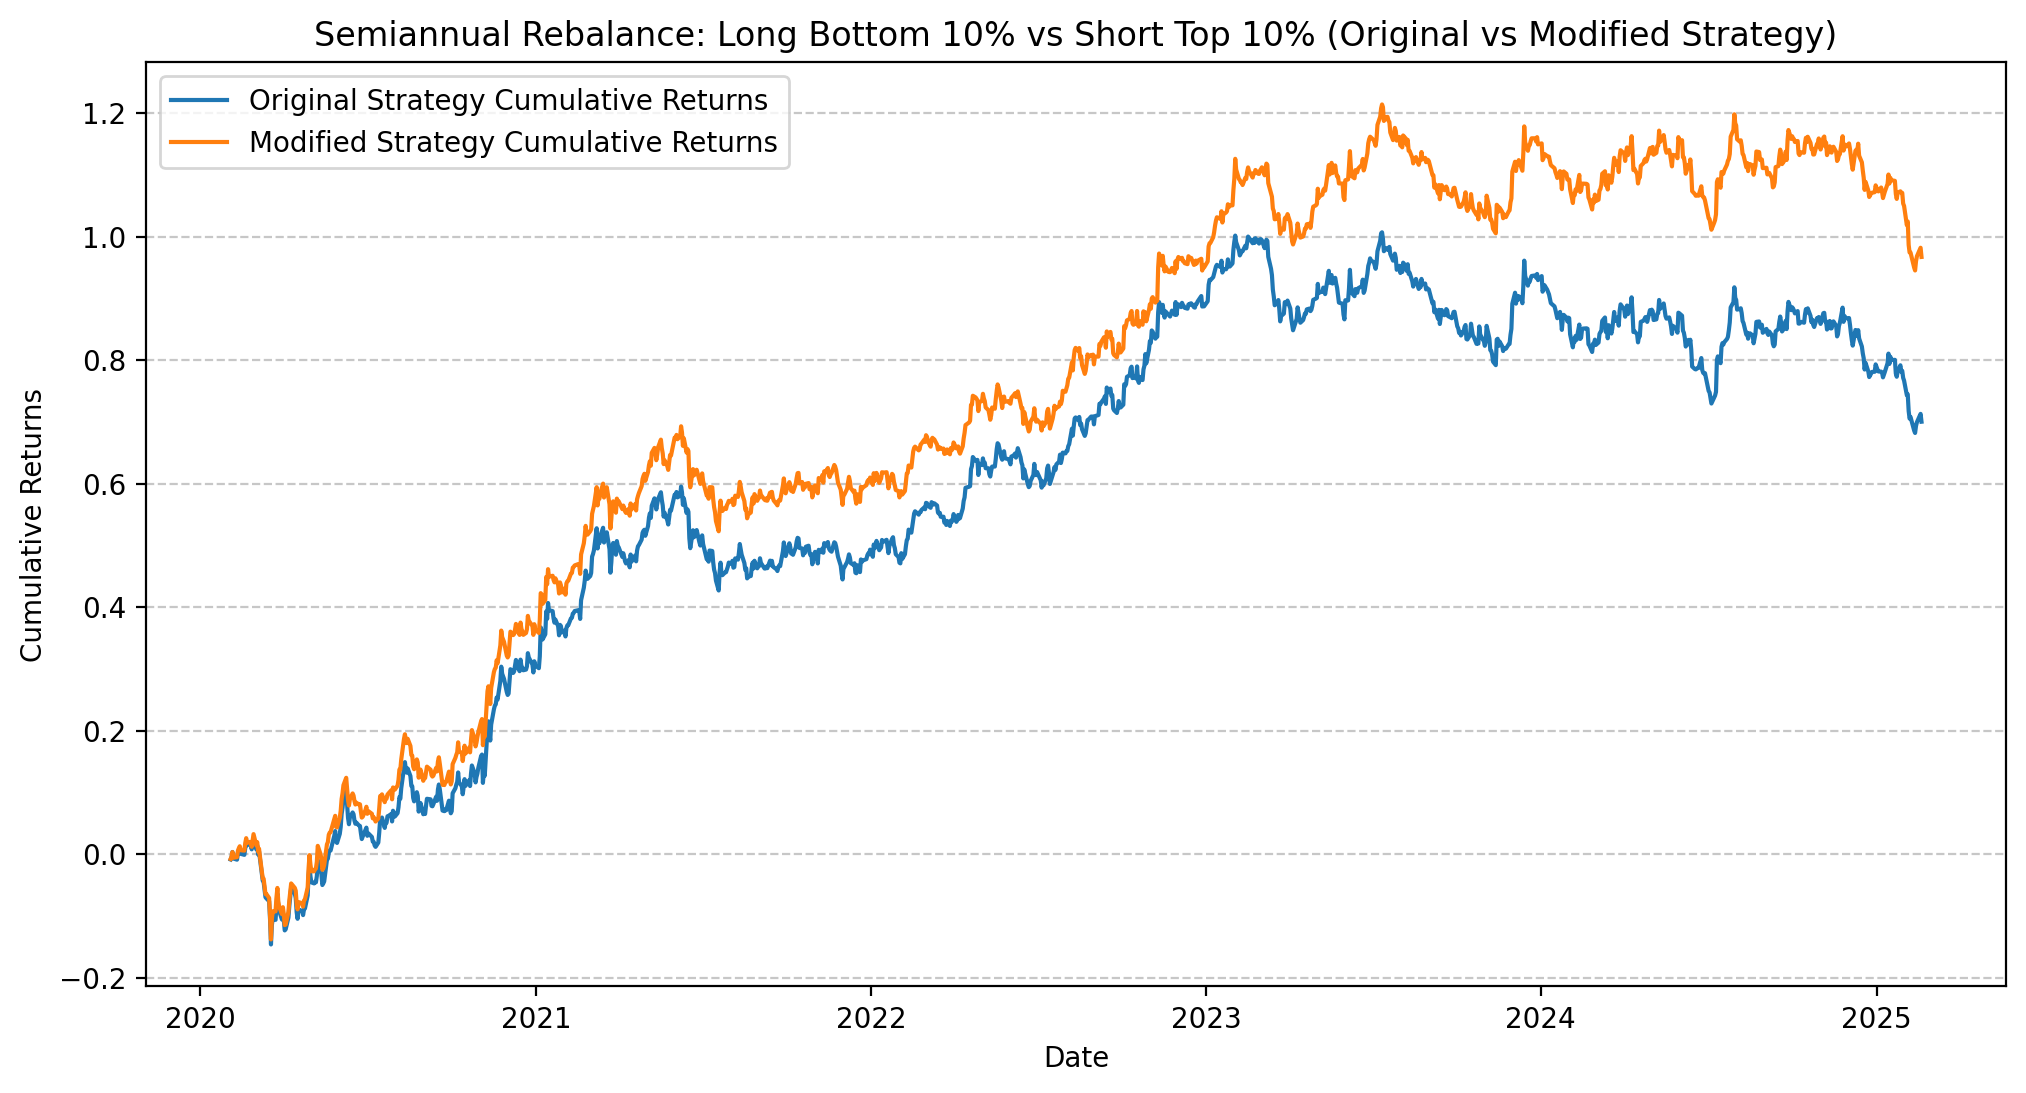

In [ ]:
# ---------------------------
# 6. Performance Evaluation and Plotting
# ---------------------------
# Calculate cumulative returns

best_limit=0.001
cumulative_original = (1 + original_strat_returns).cumprod() - 1
cumulative_modified = (1 + output_dict[best_limit]).cumprod() - 1

# cumulative_modified = (1 + output_dict[best_limit]).cumprod() - 1

# Calculate annualized Sharpe Ratio (assuming risk-free rate = 0 and 252 trading days)
sharpe_original = (original_strat_returns.mean() / original_strat_returns.std()) * np.sqrt(252)
sharpe_modified = (output_dict[best_limit].mean() / output_dict[best_limit].std()) * np.sqrt(252)

# sharpe_modified = (output_dict[best_limit].mean() / output_dict[best_limit].std()) * np.sqrt(252)

print("Annualized Sharpe Ratio (Original Strategy):", sharpe_original.round(4))
print("Annualized Sharpe Ratio (Modified Strategy):", sharpe_modified.round(4))

# Plot cumulative returns comparison
plt.figure(figsize=(12, 6),dpi=200)
plt.plot(cumulative_original, label='Original Strategy Cumulative Returns')
plt.plot(cumulative_modified, label='Modified Strategy Cumulative Returns')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Semiannual Rebalance: Long Bottom 10% vs Short Top 10% (Original vs Modified Strategy)")
plt.legend()
plt.show()

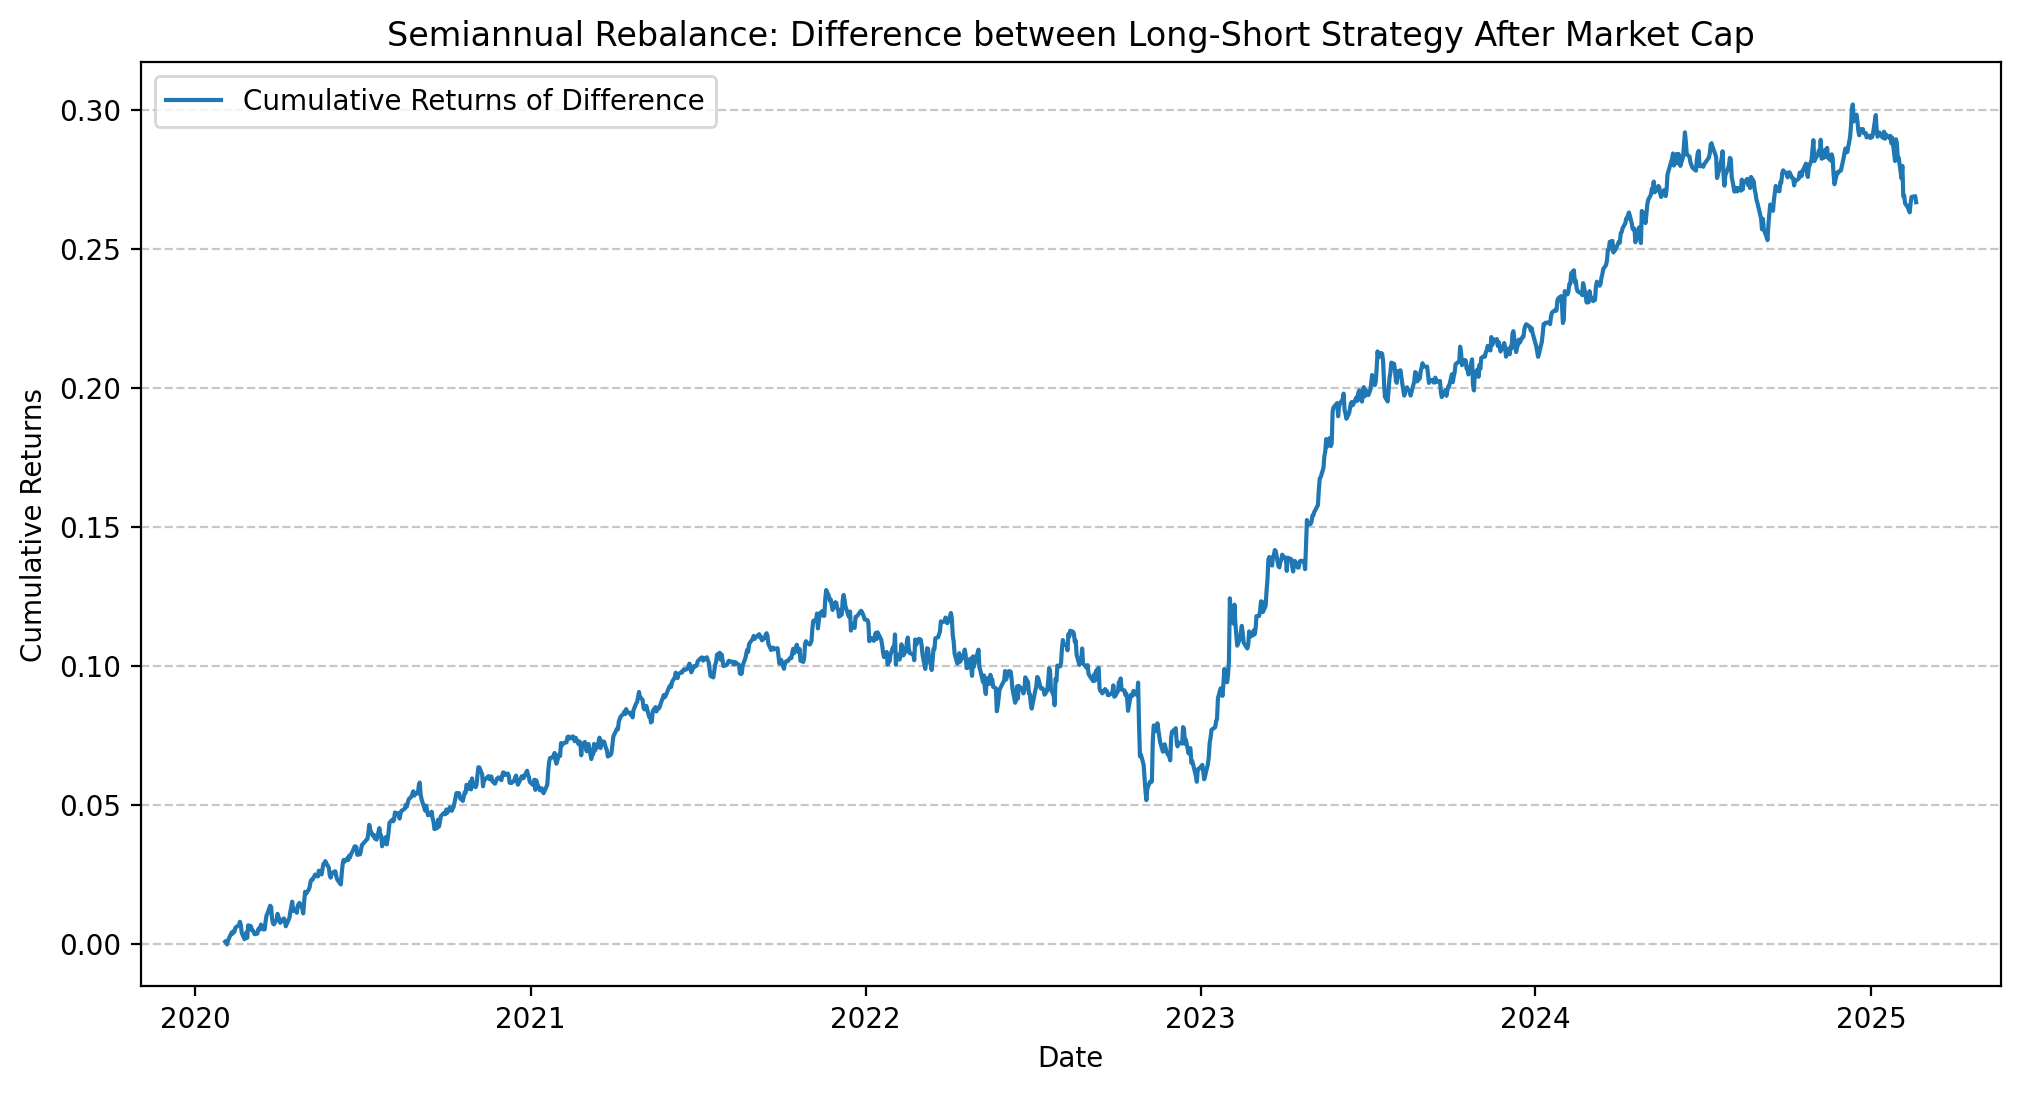

In [ ]:
# the value of improved strategy
strat_diff=cumulative_modified-cumulative_original
plt.figure(figsize=(12, 6),dpi=200)
plt.plot(cumulative_modified-cumulative_original, label='Cumulative Returns of Difference')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Semiannual Rebalance: Difference between Long-Short Strategy After Market Cap")
plt.legend()
plt.show()

In [ ]:
#download exogenous variable - VIX data
vix_data = yf.download("^VIX", start=returns.index[0].strftime('%Y-%m-%d'),
                       end=returns.index[-1].strftime('%Y-%m-%d'))
vix_close = vix_data['Close']
vix_close = vix_close.reindex(returns.index, method='ffill')
vix_ret = vix_close.pct_change().fillna(0)
vix_ret.name = 'VIX_ret'

# ---------------------------
# Adjusted Strategy Based on VAR-X Model
# ---------------------------
from statsmodels.tsa.statespace.varmax import VARMAX

# VAR-X Window and short position limit

import warnings
warnings.filterwarnings('ignore')

[*********************100%***********************]  1 of 1 completed


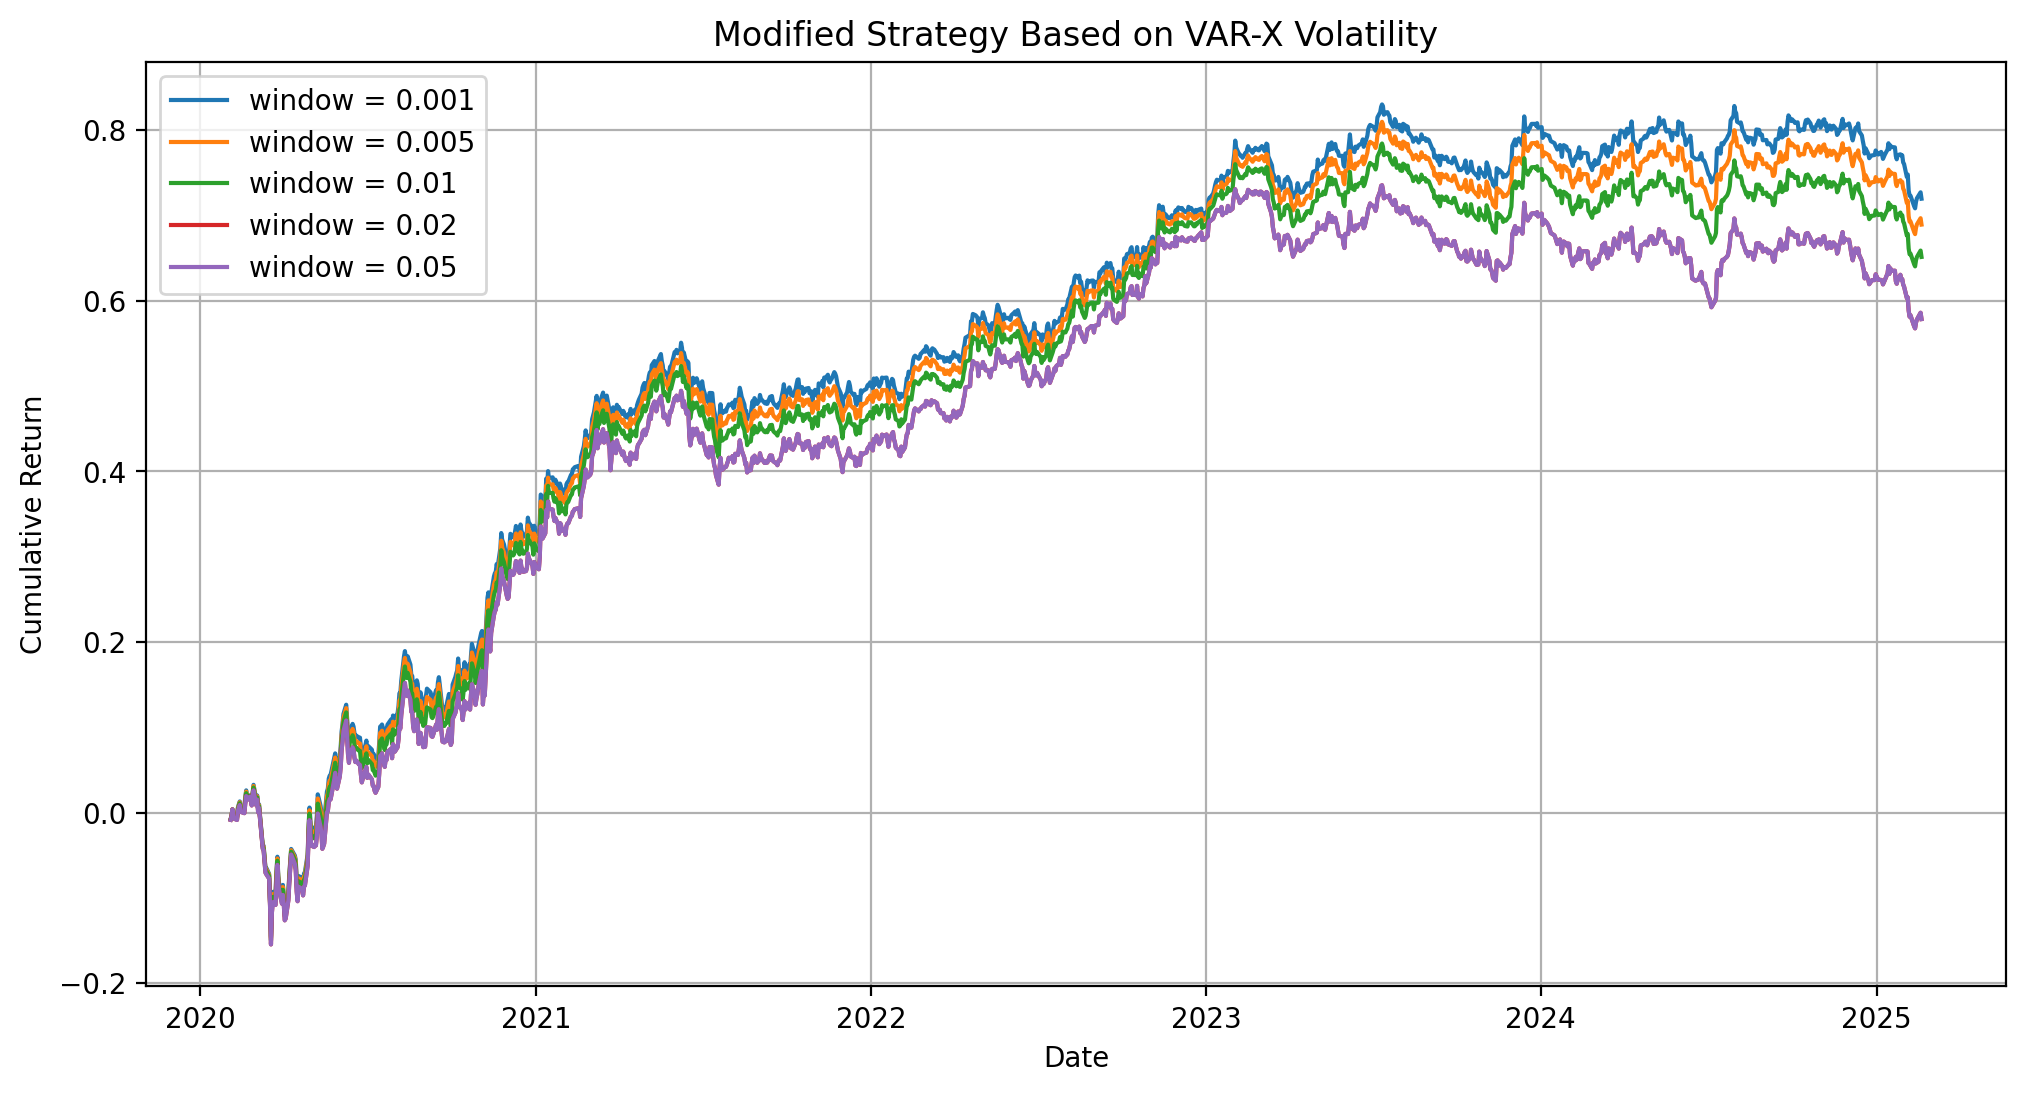

In [ ]:
c = 0.001
windows = [10,20,30,60]
output_dict_2 = {}

for window in windows:
    varx_adjusted_strat_returns = pd.Series(dtype=float)

    # calculate return during rebel dates
    for i, r_date in enumerate(rebal_dates):
        # define time slot of rebel dates
        if i < len(rebal_dates) - 1:
            next_r_date = rebal_dates[i+1]
            period = returns.loc[r_date: next_r_date - pd.Timedelta(days=1)]
        else:
            period = returns.loc[r_date:]

        # effective stocks on that day
        available_tickers = returns.columns[returns.loc[r_date].notna()]
        mcap_today = market_caps.loc[r_date, available_tickers]

        # sort long and short according to market cap
        long_threshold = mcap_today.quantile(0.10)
        short_threshold = mcap_today.quantile(0.90)
        long_stocks = mcap_today[mcap_today <= long_threshold].index.tolist()
        short_stocks = mcap_today[mcap_today >= short_threshold].index.tolist()

        # long position weight
        long_weight = 1.0 / len(long_stocks) if long_stocks else 0

        # 空头仓位先设定基准等权，然后对 Mag7 中的股票进行上限限制
        n_short = len(short_stocks)
        base_weight = 1.0 / n_short if n_short > 0 else 0
        weights = {}
        upper_limit = c
        total_reduction = 0.0
        mag7_in_short = [stock for stock in short_stocks if stock in mag7]
        non_mag7_in_short = [stock for stock in short_stocks if stock not in mag7_in_short]

        for stock in short_stocks:
            if stock in mag7_in_short and base_weight > upper_limit:
                weights[stock] = upper_limit
                total_reduction += (base_weight - upper_limit)
            else:
                weights[stock] = base_weight

        # 将减少的空头权重在非 Mag7 股票中均摊
        if non_mag7_in_short and total_reduction > 0:
            extra_weight = total_reduction / len(non_mag7_in_short)
            for stock in non_mag7_in_short:
                weights[stock] += extra_weight

        # 计算本周期每天的策略收益（多头收益减去空头收益）
        period_returns = []
        for date, row in period.iterrows():
            long_ret = sum(long_weight * row[stock] for stock in long_stocks) if long_stocks else 0
            short_ret = sum(weights[stock] * row[stock] for stock in short_stocks) if short_stocks else 0
            period_returns.append(long_ret - short_ret)
        period_returns_series = pd.Series(period_returns, index=period.index)

        # ---------------------------
        # VAR-X 调整步骤：利用过去 window 天数据拟合 VAR-X 模型，
        # 预测下一期（本周期第一天）的预测误差方差，并计算风险调整因子
        # 如果历史数据不足则不调整
        # ---------------------------
        if len(varx_adjusted_strat_returns) >= window:
            # 取过去 window 天的策略收益（这里使用已经调整后的策略收益）
            hist_index = varx_adjusted_strat_returns.index[-window:]
            hist_strategy = varx_adjusted_strat_returns.loc[hist_index]
            hist_vix = vix_ret.loc[hist_index]
            varx_data = pd.concat([hist_strategy, hist_vix], axis=1).dropna()
            varx_data.columns = ['Strategy', 'VIX_ret']

            try:
                varx_model = VARMAX(varx_data[['Strategy']], exog=varx_data[['VIX_ret']], order=(1, 0))
                varx_fit = varx_model.fit(disp=False)
                # 对本周期的首日进行1步预测，需提供对应日期的外生变量（这里使用 VIX 当天数据）
                if not period_returns_series.empty:
                    exog_forecast = vix_ret.loc[period_returns_series.index[0]:period_returns_series.index[0]]
                    forecast_obj = varx_fit.get_forecast(steps=10, exog=exog_forecast.to_frame())
                    # 获取预测均值方差，这里我们只用第一步预测的误差方差
                    forecast_var = forecast_obj.var_pred_mean.iloc[0, 0]
                    # 风险调整因子：预测方差越大，调整因子越小（降低仓位）
                    adjustment_factor = 1 / (1 + forecast_var)
                else:
                    adjustment_factor = 0.9
            except Exception as e:
                # 如果VAR-X模型拟合失败，则默认不调整
                adjustment_factor = 0.9
        else:
            adjustment_factor = 0.9

        # 将本周期的策略收益乘以风险调整因子
        period_returns_series_adjusted = period_returns_series * adjustment_factor

        # 将调整后的收益拼接到总的收益序列中
        varx_adjusted_strat_returns = pd.concat([varx_adjusted_strat_returns, period_returns_series_adjusted])

    varx_adjusted_strat_returns.sort_index(inplace=True)
    output_dict_2[window] = varx_adjusted_strat_returns


plt.figure(figsize=(12,6),dpi=200)
for window, series in output_dict.items():
    plt.plot(series.index, series.cumsum(), label=f'window = {window}')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Modified Strategy Based on VAR-X Volatility")
plt.legend()
plt.grid(True)
plt.show()


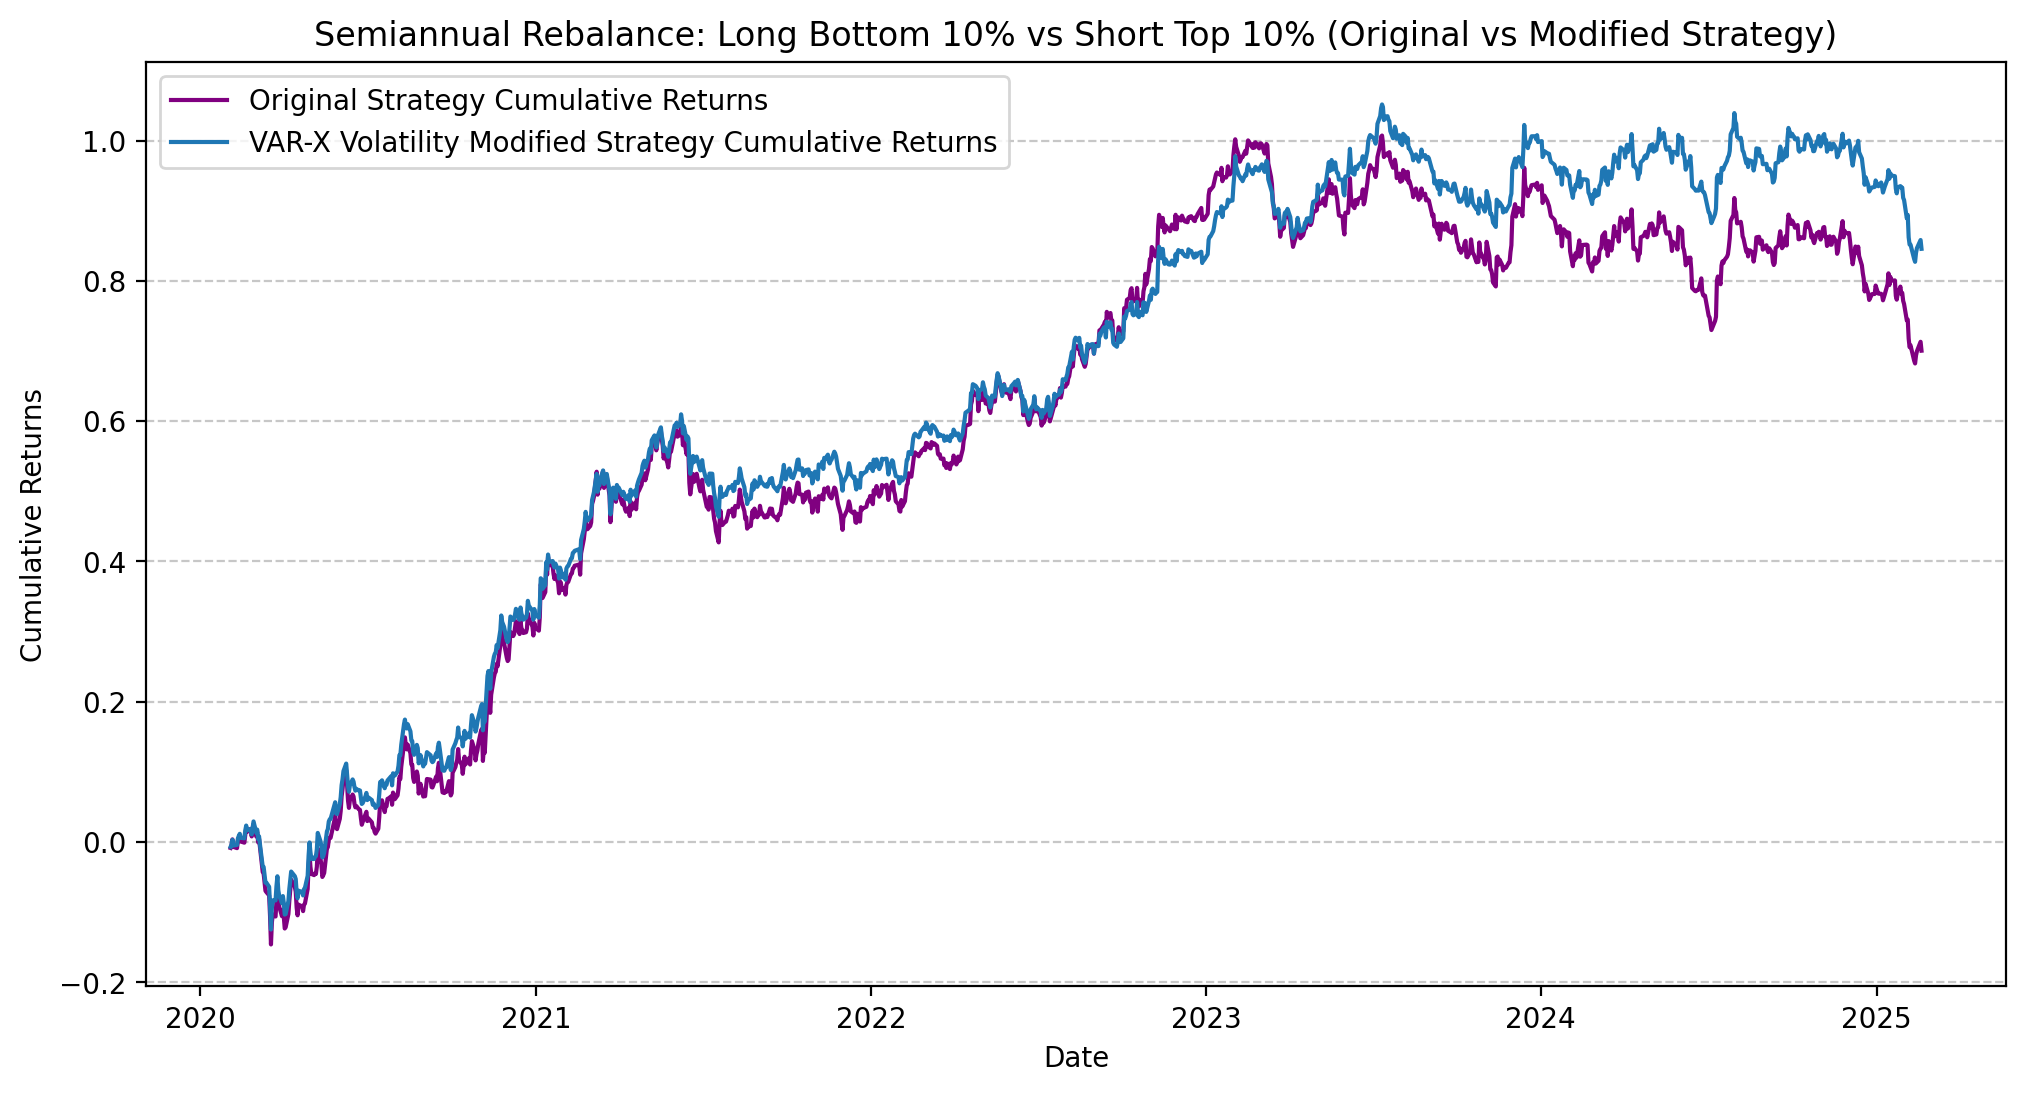

In [ ]:
# Plot cumulative returns comparison
plt.figure(figsize=(12, 6),dpi=200)
plt.plot(cumulative_original, label='Original Strategy Cumulative Returns',color='purple')
plt.plot((1+output_dict_2[30]).cumprod()-1, label='VAR-X Volatility Modified Strategy Cumulative Returns')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Semiannual Rebalance: Long Bottom 10% vs Short Top 10% (Original vs Modified Strategy)")
plt.legend()
plt.show()

In [ ]:
!pip install quantstats
!pip install pyfolio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88656 sha256=8b31d4c7d27f2c4b02655b9a10a0d7a0b3764e5d7a3c0227d14be2c3453a8337
  Stored in directory: /root/.cache/pip/wheels/f9/af/9e/7c343b822164a3147a3d395a1bcd05041c520a3bc6398fe88e
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39753 sha256=0018fb078a71a8b15102197a4039f97be41511c8efa42cccf5f45d01171d11cb
  Stored in directory: /root/.cache/pip/wheels/ac/1d/58/a7ae5ef5c8de7c4b769f24c2584f4706564921f031b16b9cb6
Successfully built pyfolio empyrical


In [ ]:
import quantstats as qs
import pyfolio as pf

In [ ]:
qs.reports.metrics(original_strat_returns,mode="basic")

                    Strategy
------------------  ----------
Start Period        2020-02-03
End Period          2025-02-19
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   70.04%
CAGR﹪              7.53%

Sharpe              0.83
Prob. Sharpe Ratio  97.08%
Sortino             1.28
Sortino/√2          0.91
Omega               1.15

Max Drawdown        -16.76%
Longest DD Days     588

Gain/Pain Ratio     0.15
Gain/Pain (1M)      0.96

Payoff Ratio        1.06
Profit Factor       1.15
Common Sense Ratio  1.38
CPC Index           0.64
Tail Ratio          1.2
Outlier Win Ratio   3.62
Outlier Loss Ratio  3.12

MTD                 -3.77%
3M                  -8.36%
6M                  -7.76%
YTD                 -5.18%
1Y                  -8.15%
3Y (ann.)           2.27%
5Y (ann.)           10.13%
10Y (ann.)          7.53%
All-time (ann.)     7.53%

Avg. Drawdown       -2.63%
Avg. Drawdown Days  34
Recovery Factor     3.45
Ulcer Index         0.06
Serenity Index      0.79

In [ ]:
qs.reports.metrics(output_dict[best_limit],mode="basic")

                    Strategy
------------------  ----------
Start Period        2020-02-03
End Period          2025-02-19
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   98.1%
CAGR﹪              9.8%

Sharpe              1.11
Prob. Sharpe Ratio  99.4%
Sortino             1.72
Sortino/√2          1.22
Omega               1.21

Max Drawdown        -16.5%
Longest DD Days     588

Gain/Pain Ratio     0.21
Gain/Pain (1M)      1.43

Payoff Ratio        1.06
Profit Factor       1.21
Common Sense Ratio  1.56
CPC Index           0.68
Tail Ratio          1.29
Outlier Win Ratio   3.72
Outlier Loss Ratio  3.07

MTD                 -4.04%
3M                  -7.94%
6M                  -7.07%
YTD                 -5.58%
1Y                  -5.58%
3Y (ann.)           4.24%
5Y (ann.)           12.36%
10Y (ann.)          9.8%
All-time (ann.)     9.8%

Avg. Drawdown       -2.41%
Avg. Drawdown Days  33
Recovery Factor     4.4
Ulcer Index         0.04
Serenity Index      1.65
